# Word2Vec: Variations, Similarity, and Word Relationships

This notebook covers Word2Vec in depth — two architectures (CBOW and Skip-gram),
training from scratch, cosine similarity across many word groups, most-similar queries,
embedding arithmetic, and visualizations.

All experiments use the same dataset so results are directly comparable across architectures.

---

**Sections**

1. Setup and dataset loading
2. Vocabulary building
3. CBOW model — training
4. Skip-gram model — training
5. Negative sampling Skip-gram — training
6. Training loss comparison across all three models
7. Cosine similarity — word pairs across many categories
8. Most similar words — top-N queries for many words
9. Least similar words
10. Word analogy / embedding arithmetic
11. Similarity change: random vs trained vs more epochs
12. PCA visualization — all three models side by side
13. t-SNE visualization
14. Cosine similarity heatmap
15. Nearest neighbor table for selected words
16. Summary and comparison table

---
## Cell 1 — Imports and Version Check

In [20]:
# Uncomment to install
# !pip install torch requests matplotlib scikit-learn

import sys
import re
import math
import random
import os
from collections import Counter
from importlib.metadata import version

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity as cos_matrix

print("Python  :", sys.version[:20])
print("torch   :", version("torch"))
print("numpy   :", version("numpy"))

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Python  : 3.10.11 (tags/v3.10.
torch   : 2.10.0
numpy   : 2.2.6


---
## Cell 2 — Load Dataset

In [21]:
import requests

if not os.path.exists("the-verdict.txt"):
    url = (
        "https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"
    )
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    with open("the-verdict.txt", "wb") as f:
        f.write(r.content)
    print("Downloaded the-verdict.txt")

with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print(f"Characters : {len(raw_text):,}")
print(f"Words      : {len(raw_text.split()):,}")
print(f"Preview    : {raw_text[:120]}")

Characters : 20,479
Words      : 3,634
Preview    : I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me 


---
## Cell 3 — Vocabulary Building

Clean the text, count word frequencies, keep the top-N most frequent words.
Words below the frequency threshold are discarded to reduce noise.

In [22]:
def build_vocab(text, max_vocab=800, min_freq=2):
    """
    Tokenize raw text into lowercase words (letters only),
    build a frequency-filtered vocabulary.

    Returns:
        words     : full list of tokens present in vocab
        vocab     : list of vocab words
        w2i       : word -> index
        i2w       : index -> word
    """
    raw_words = text.lower().split()
    raw_words = [re.sub(r'[^a-z]', '', w) for w in raw_words]
    raw_words = [w for w in raw_words if len(w) >= 2]

    freq  = Counter(raw_words)
    vocab = [w for w, c in freq.most_common(max_vocab) if c >= min_freq]

    w2i = {w: i for i, w in enumerate(vocab)}
    i2w = {i: w for w, i in w2i.items()}

    # Keep only words in vocabulary
    words = [w for w in raw_words if w in w2i]

    return words, vocab, w2i, i2w


words, vocab, w2i, i2w = build_vocab(raw_text, max_vocab=800, min_freq=2)
V = len(vocab)

print(f"Vocabulary size    : {V}")
print(f"Total tokens kept  : {len(words):,}")
print(f"Unique token ratio : {V / len(set(words)):.2f}")

print("\nTop 20 most frequent words:")
freq = Counter(words)
for w, c in freq.most_common(20):
    bar = "|" * (c // 5)
    print(f"  {w:<12} {c:>5}  {bar}")

Vocabulary size    : 381
Total tokens kept  : 2,662
Unique token ratio : 1.00

Top 20 most frequent words:
  the            179  |||||||||||||||||||||||||||||||||||
  of             102  ||||||||||||||||||||
  to             100  ||||||||||||||||||||
  and             75  |||||||||||||||
  he              74  ||||||||||||||
  was             71  ||||||||||||||
  it              68  |||||||||||||
  his             60  ||||||||||||
  that            55  |||||||||||
  had             53  ||||||||||
  my              42  ||||||||
  in              41  ||||||||
  me              33  ||||||
  with            32  ||||||
  him             30  ||||||
  on              26  |||||
  have            26  |||||
  you             25  |||||
  she             24  ||||
  mrs             22  ||||


---
## Cell 4 — Training Data Builders

Two different data formats are needed:
- CBOW: (list of context word IDs, center word ID)
- Skip-gram: (center word ID, one context word ID) — one pair per context word

In [23]:
def build_cbow_data(words, w2i, window=2):
    """
    For each center word, collect all context words within the window.
    Returns list of ([ctx_ids], center_id)
    """
    data = []
    for i in range(window, len(words) - window):
        ctx = ([words[i-j] for j in range(window, 0, -1)] +
               [words[i+j] for j in range(1, window+1)])
        ctr = words[i]
        if all(w in w2i for w in ctx) and ctr in w2i:
            data.append(([w2i[w] for w in ctx], w2i[ctr]))
    return data


def build_skipgram_data(words, w2i, window=2):
    """
    For each center word, produce one (center, context) pair per context word.
    Returns list of (center_id, context_id)
    """
    data = []
    for i in range(window, len(words) - window):
        ctr = words[i]
        if ctr not in w2i:
            continue
        for j in list(range(-window, 0)) + list(range(1, window+1)):
            ctx = words[i+j]
            if ctx in w2i:
                data.append((w2i[ctr], w2i[ctx]))
    return data


WINDOW = 2
cbow_data     = build_cbow_data(words, w2i, window=WINDOW)
skipgram_data = build_skipgram_data(words, w2i, window=WINDOW)

random.shuffle(cbow_data)
random.shuffle(skipgram_data)

print(f"CBOW training pairs     : {len(cbow_data):,}")
print(f"Skip-gram training pairs: {len(skipgram_data):,}")
print(f"\nSample CBOW pair:")
ctx_ids, ctr_id = cbow_data[0]
print(f"  Context : {[i2w[i] for i in ctx_ids]}")
print(f"  Center  : {i2w[ctr_id]}")
print(f"\nSample Skip-gram pair:")
ctr_id, ctx_id = skipgram_data[0]
print(f"  Center  : {i2w[ctr_id]}")
print(f"  Context : {i2w[ctx_id]}")

CBOW training pairs     : 2,658
Skip-gram training pairs: 10,632

Sample CBOW pair:
  Context : ['had', 'done', 'with', 'any']
  Center  : that

Sample Skip-gram pair:
  Center  : for
  Context : her


---
## Cell 5 — Model Definitions

Three architectures:

**CBOW** — averages context embeddings, predicts center word via softmax over full vocabulary.

**Skip-gram** — takes center word embedding, predicts each context word via softmax over full vocabulary.

**Skip-gram with Negative Sampling** — instead of computing softmax over the full vocabulary (expensive), treats the task as binary classification: is this a real (center, context) pair or a noise pair? Faster and often better for larger vocabularies.

In [24]:
class CBOWModel(nn.Module):
    """
    CBOW: average context embeddings -> linear -> softmax
    Input : context word IDs (batch, 2*window)
    Output: logits over vocabulary (batch, vocab_size)
    """
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear    = nn.Linear(embed_dim, vocab_size)

    def forward(self, ctx_ids):
        embeds = self.embedding(ctx_ids)   # (batch, ctx_len, dim)
        mean   = embeds.mean(dim=1)        # (batch, dim)
        return self.linear(mean)           # (batch, vocab)

    def get_embeddings(self):
        return self.embedding.weight.detach()


class SkipGramModel(nn.Module):
    """
    Skip-gram: center embedding -> linear -> softmax
    Input : center word ID (batch,)
    Output: logits over vocabulary (batch, vocab_size)
    """
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.linear    = nn.Linear(embed_dim, vocab_size)

    def forward(self, center_ids):
        embeds = self.embedding(center_ids)   # (batch, dim)
        return self.linear(embeds)            # (batch, vocab)

    def get_embeddings(self):
        return self.embedding.weight.detach()


class SkipGramNegSampling(nn.Module):
    """
    Skip-gram with Negative Sampling.
    Uses two separate embedding tables:
      - center_embed  : embeddings for center words
      - context_embed : embeddings for context words
    Binary classification loss instead of full softmax.
    """
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.center_embed  = nn.Embedding(vocab_size, embed_dim)
        self.context_embed = nn.Embedding(vocab_size, embed_dim)
        # Initialize small to avoid saturation
        nn.init.uniform_(self.center_embed.weight,  -0.1, 0.1)
        nn.init.uniform_(self.context_embed.weight, -0.1, 0.1)

    def forward(self, center_ids, context_ids, neg_ids):
        """
        center_ids  : (batch,)
        context_ids : (batch,)
        neg_ids     : (batch, num_neg)
        """
        c_emb   = self.center_embed(center_ids)          # (batch, dim)
        pos_emb = self.context_embed(context_ids)        # (batch, dim)
        neg_emb = self.context_embed(neg_ids)            # (batch, num_neg, dim)

        # Positive score: dot product of center and real context
        pos_score = torch.sum(c_emb * pos_emb, dim=1)   # (batch,)
        pos_loss  = F.logsigmoid(pos_score)

        # Negative score: dot product with noise words
        neg_score = torch.bmm(neg_emb, c_emb.unsqueeze(2)).squeeze(2)  # (batch, num_neg)
        neg_loss  = F.logsigmoid(-neg_score).sum(dim=1)

        return -(pos_loss + neg_loss).mean()

    def get_embeddings(self):
        # Average center and context embeddings (common practice)
        return (self.center_embed.weight + self.context_embed.weight).detach() / 2


print("Models defined:")
print("  CBOWModel            - CBOW with full softmax")
print("  SkipGramModel        - Skip-gram with full softmax")
print("  SkipGramNegSampling  - Skip-gram with negative sampling")

Models defined:
  CBOWModel            - CBOW with full softmax
  SkipGramModel        - Skip-gram with full softmax
  SkipGramNegSampling  - Skip-gram with negative sampling


---
## Cell 6 — Training Function

In [25]:
def train_cbow(model, data, epochs=10, batch_size=256, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history   = []

    for epoch in range(epochs):
        random.shuffle(data)
        total, steps = 0.0, 0
        for start in range(0, len(data), batch_size):
            batch   = data[start:start+batch_size]
            ctx_t   = torch.tensor([d[0] for d in batch])
            ctr_t   = torch.tensor([d[1] for d in batch])
            optimizer.zero_grad()
            loss = criterion(model(ctx_t), ctr_t)
            loss.backward()
            optimizer.step()
            total += loss.item()
            steps += 1
        avg = total / steps
        history.append(avg)
        print(f"  Epoch {epoch+1:>2}/{epochs}  loss: {avg:.4f}")

    return history


def train_skipgram(model, data, epochs=10, batch_size=256, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history   = []

    for epoch in range(epochs):
        random.shuffle(data)
        total, steps = 0.0, 0
        for start in range(0, len(data), batch_size):
            batch   = data[start:start+batch_size]
            ctr_t   = torch.tensor([d[0] for d in batch])
            ctx_t   = torch.tensor([d[1] for d in batch])
            optimizer.zero_grad()
            loss = criterion(model(ctr_t), ctx_t)
            loss.backward()
            optimizer.step()
            total += loss.item()
            steps += 1
        avg = total / steps
        history.append(avg)
        print(f"  Epoch {epoch+1:>2}/{epochs}  loss: {avg:.4f}")

    return history


def train_neg_sampling(model, data, vocab_size, epochs=10,
                       batch_size=256, lr=0.01, num_neg=5):
    """
    Negative sampling: for each real (center, context) pair,
    sample num_neg noise words from the vocabulary.
    Noise distribution is uniform here; in the original paper
    it is proportional to word_freq^0.75.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history   = []

    for epoch in range(epochs):
        random.shuffle(data)
        total, steps = 0.0, 0
        for start in range(0, len(data), batch_size):
            batch   = data[start:start+batch_size]
            ctr_t   = torch.tensor([d[0] for d in batch])
            ctx_t   = torch.tensor([d[1] for d in batch])
            neg_t   = torch.randint(0, vocab_size, (len(batch), num_neg))
            optimizer.zero_grad()
            loss = model(ctr_t, ctx_t, neg_t)
            loss.backward()
            optimizer.step()
            total += loss.item()
            steps += 1
        avg = total / steps
        history.append(avg)
        print(f"  Epoch {epoch+1:>2}/{epochs}  loss: {avg:.4f}")

    return history


print("Training functions ready.")

Training functions ready.


---
## Cell 7 — Train CBOW

In [26]:
EMBED_DIM = 64
EPOCHS    = 15
BATCH     = 256
LR        = 0.01

print(f"Training CBOW  (vocab={V}, dim={EMBED_DIM}, epochs={EPOCHS})")
cbow_model   = CBOWModel(V, EMBED_DIM)
cbow_history = train_cbow(cbow_model, cbow_data, epochs=EPOCHS, batch_size=BATCH, lr=LR)
cbow_emb     = cbow_model.get_embeddings()
print(f"\nCBOW embedding matrix shape: {cbow_emb.shape}")

Training CBOW  (vocab=381, dim=64, epochs=15)
  Epoch  1/15  loss: 5.7932
  Epoch  2/15  loss: 5.0795
  Epoch  3/15  loss: 4.6088
  Epoch  4/15  loss: 4.2605
  Epoch  5/15  loss: 3.9677
  Epoch  6/15  loss: 3.6649
  Epoch  7/15  loss: 3.4172
  Epoch  8/15  loss: 3.1372
  Epoch  9/15  loss: 2.9091
  Epoch 10/15  loss: 2.7047
  Epoch 11/15  loss: 2.4933
  Epoch 12/15  loss: 2.3058
  Epoch 13/15  loss: 2.1438
  Epoch 14/15  loss: 1.9910
  Epoch 15/15  loss: 1.8589

CBOW embedding matrix shape: torch.Size([381, 64])


---
## Cell 8 — Train Skip-gram (Full Softmax)

In [27]:
print(f"Training Skip-gram  (vocab={V}, dim={EMBED_DIM}, epochs={EPOCHS})")
sg_model   = SkipGramModel(V, EMBED_DIM)
sg_history = train_skipgram(sg_model, skipgram_data, epochs=EPOCHS, batch_size=BATCH, lr=LR)
sg_emb     = sg_model.get_embeddings()
print(f"\nSkip-gram embedding matrix shape: {sg_emb.shape}")

Training Skip-gram  (vocab=381, dim=64, epochs=15)
  Epoch  1/15  loss: 5.7326
  Epoch  2/15  loss: 4.9266
  Epoch  3/15  loss: 4.6239
  Epoch  4/15  loss: 4.4487
  Epoch  5/15  loss: 4.3302
  Epoch  6/15  loss: 4.2325
  Epoch  7/15  loss: 4.1583
  Epoch  8/15  loss: 4.0932
  Epoch  9/15  loss: 4.0470
  Epoch 10/15  loss: 4.0112
  Epoch 11/15  loss: 3.9750
  Epoch 12/15  loss: 3.9479
  Epoch 13/15  loss: 3.9279
  Epoch 14/15  loss: 3.9020
  Epoch 15/15  loss: 3.8909

Skip-gram embedding matrix shape: torch.Size([381, 64])


---
## Cell 9 — Train Skip-gram with Negative Sampling

In [28]:
print(f"Training Skip-gram + Negative Sampling  (vocab={V}, dim={EMBED_DIM}, epochs={EPOCHS})")
sgns_model   = SkipGramNegSampling(V, EMBED_DIM)
sgns_history = train_neg_sampling(sgns_model, skipgram_data, V,
                                   epochs=EPOCHS, batch_size=BATCH, lr=LR, num_neg=5)
sgns_emb     = sgns_model.get_embeddings()
print(f"\nSGNS embedding matrix shape: {sgns_emb.shape}")

Training Skip-gram + Negative Sampling  (vocab=381, dim=64, epochs=15)
  Epoch  1/15  loss: 3.3591
  Epoch  2/15  loss: 2.1684
  Epoch  3/15  loss: 2.0629
  Epoch  4/15  loss: 1.9512
  Epoch  5/15  loss: 1.8138
  Epoch  6/15  loss: 1.6935
  Epoch  7/15  loss: 1.5858
  Epoch  8/15  loss: 1.4955
  Epoch  9/15  loss: 1.4270
  Epoch 10/15  loss: 1.3694
  Epoch 11/15  loss: 1.3226
  Epoch 12/15  loss: 1.3034
  Epoch 13/15  loss: 1.2710
  Epoch 14/15  loss: 1.2573
  Epoch 15/15  loss: 1.2564

SGNS embedding matrix shape: torch.Size([381, 64])


---
## Cell 10 — Training Loss Comparison

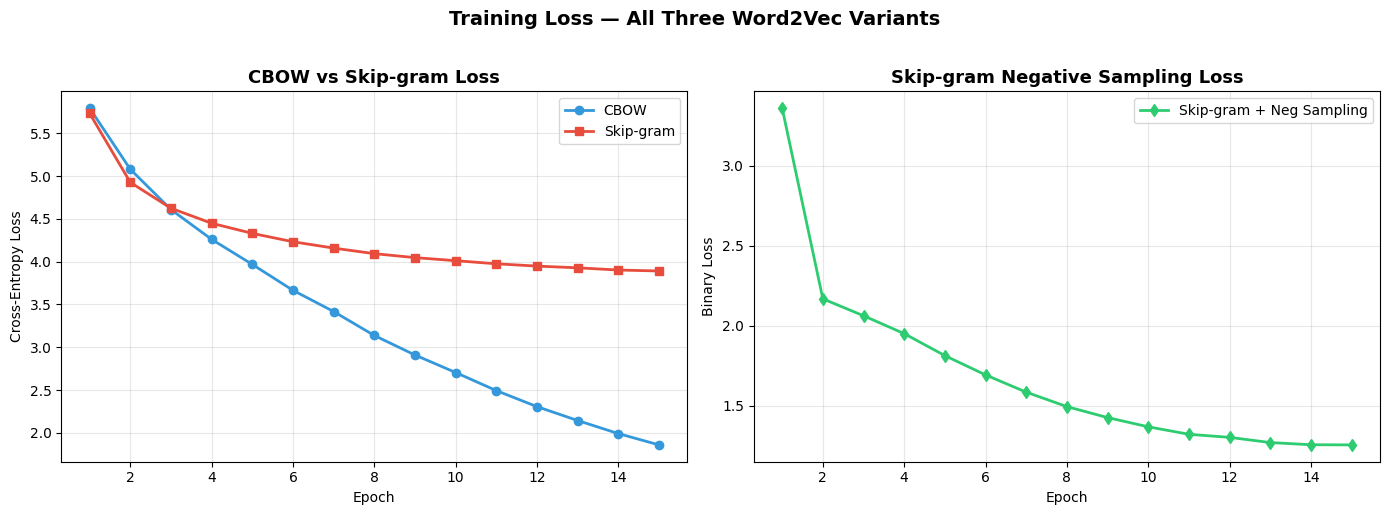

Saved: w2v_loss_comparison.png

Final losses:
  CBOW              : 1.8589
  Skip-gram         : 3.8909
  SGNS              : 1.2564


In [29]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, EPOCHS+1)

# Left: CBOW and Skip-gram (same loss scale)
ax = axes[0]
ax.plot(epochs_range, cbow_history, 'o-', color='#3498db',
        linewidth=2, markersize=6, label='CBOW')
ax.plot(epochs_range, sg_history,   's-', color='#e74c3c',
        linewidth=2, markersize=6, label='Skip-gram')
ax.set_title("CBOW vs Skip-gram Loss", fontsize=13, fontweight='bold')
ax.set_xlabel("Epoch"); ax.set_ylabel("Cross-Entropy Loss")
ax.legend(fontsize=10); ax.grid(True, alpha=0.3)

# Right: Negative sampling (different loss scale — binary CE)
ax2 = axes[1]
ax2.plot(epochs_range, sgns_history, 'd-', color='#2ecc71',
         linewidth=2, markersize=6, label='Skip-gram + Neg Sampling')
ax2.set_title("Skip-gram Negative Sampling Loss", fontsize=13, fontweight='bold')
ax2.set_xlabel("Epoch"); ax2.set_ylabel("Binary Loss")
ax2.legend(fontsize=10); ax2.grid(True, alpha=0.3)

plt.suptitle("Training Loss — All Three Word2Vec Variants",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("w2v_loss_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: w2v_loss_comparison.png")

print(f"\nFinal losses:")
print(f"  CBOW              : {cbow_history[-1]:.4f}")
print(f"  Skip-gram         : {sg_history[-1]:.4f}")
print(f"  SGNS              : {sgns_history[-1]:.4f}")

---
## Cell 11 — Similarity Utility Functions

In [30]:
def get_vec(word, embeddings, w2i):
    """Return embedding vector for a word, or None if not in vocab."""
    if word not in w2i:
        return None
    return embeddings[w2i[word]]


def cosine_sim(w1, w2, embeddings, w2i):
    """Cosine similarity between two words."""
    v1 = get_vec(w1, embeddings, w2i)
    v2 = get_vec(w2, embeddings, w2i)
    if v1 is None or v2 is None:
        return None
    return F.cosine_similarity(v1.unsqueeze(0), v2.unsqueeze(0)).item()


def most_similar(word, embeddings, w2i, i2w, topn=10, exclude=None):
    """
    Find the topn most similar words to the query word.
    Excludes the query word itself and any words in the exclude list.
    """
    if word not in w2i:
        return []
    excl = {word} | (set(exclude) if exclude else set())
    vec  = embeddings[w2i[word]].unsqueeze(0)
    sims = F.cosine_similarity(vec, embeddings).detach().numpy()
    ranked = np.argsort(sims)[::-1]
    results = []
    for idx in ranked:
        w = i2w[idx]
        if w not in excl:
            results.append((w, float(sims[idx])))
        if len(results) == topn:
            break
    return results


def least_similar(word, embeddings, w2i, i2w, topn=5):
    """Find the topn least similar words to the query word."""
    if word not in w2i:
        return []
    vec  = embeddings[w2i[word]].unsqueeze(0)
    sims = F.cosine_similarity(vec, embeddings).detach().numpy()
    ranked = np.argsort(sims)   # ascending
    return [(i2w[idx], float(sims[idx])) for idx in ranked[:topn]]


def analogy(pos_words, neg_words, embeddings, w2i, i2w, topn=5):
    """
    Embedding arithmetic: sum(pos_words) - sum(neg_words).
    Returns topn nearest words to the result vector.
    """
    result  = torch.zeros(embeddings.shape[1])
    used    = []
    missing = []
    for w in pos_words:
        v = get_vec(w, embeddings, w2i)
        if v is not None:
            result += v
            used.append(f"+{w}")
        else:
            missing.append(w)
    for w in neg_words:
        v = get_vec(w, embeddings, w2i)
        if v is not None:
            result -= v
            used.append(f"-{w}")
        else:
            missing.append(w)

    result   = F.normalize(result.unsqueeze(0), dim=1).squeeze()
    sims     = F.cosine_similarity(result.unsqueeze(0), embeddings).detach().numpy()
    excl     = set(pos_words + neg_words)
    ranked   = np.argsort(sims)[::-1]
    results  = []
    for idx in ranked:
        w = i2w[idx]
        if w not in excl:
            results.append((w, float(sims[idx])))
        if len(results) == topn:
            break
    return used, missing, results


print("Utility functions defined:")
print("  get_vec(word, emb, w2i)")
print("  cosine_sim(w1, w2, emb, w2i)")
print("  most_similar(word, emb, w2i, i2w, topn)")
print("  least_similar(word, emb, w2i, i2w, topn)")
print("  analogy(pos, neg, emb, w2i, i2w, topn)")

Utility functions defined:
  get_vec(word, emb, w2i)
  cosine_sim(w1, w2, emb, w2i)
  most_similar(word, emb, w2i, i2w, topn)
  least_similar(word, emb, w2i, i2w, topn)
  analogy(pos, neg, emb, w2i, i2w, topn)


---
## Cell 12 — Cosine Similarity: Word Pairs Across Many Categories

Compare all three models on the same word pairs.

In [31]:
pair_groups = {
    "Synonyms": [
        ("good",    "great"),
        ("little",  "small"),
        ("look",    "see"),
        ("work",    "job"),
        ("happy",   "glad"),
    ],
    "Antonyms": [
        ("good",    "bad"),
        ("old",     "young"),
        ("come",    "go"),
        ("right",   "wrong"),
        ("light",   "dark"),
    ],
    "Morphological (same root)": [
        ("man",     "men"),
        ("see",     "seen"),
        ("make",    "made"),
        ("think",   "thought"),
        ("go",      "gone"),
    ],
    "Syntactic (same POS)": [
        ("run",     "walk"),
        ("hand",    "eye"),
        ("old",     "new"),
        ("he",      "she"),
        ("give",    "take"),
    ],
    "Topically related": [
        ("room",    "door"),
        ("time",    "year"),
        ("face",    "eye"),
        ("work",    "day"),
        ("life",    "world"),
    ],
    "Unrelated": [
        ("door",    "think"),
        ("eye",     "come"),
        ("hand",    "right"),
        ("time",    "man"),
        ("old",     "room"),
    ],
}

models = [
    ("CBOW",  cbow_emb),
    ("SG",    sg_emb),
    ("SGNS",  sgns_emb),
]

for group_name, pairs in pair_groups.items():
    print("=" * 70)
    print(f"  {group_name}")
    print("=" * 70)
    print(f"  {'Word 1':<10} {'Word 2':<10}  {'CBOW':>8}  {'SG':>8}  {'SGNS':>8}")
    print("  " + "-" * 50)
    for w1, w2 in pairs:
        row = f"  {w1:<10} {w2:<10}"
        for name, emb in models:
            s = cosine_sim(w1, w2, emb, w2i)
            if s is not None:
                row += f"  {s:>+8.4f}"
            else:
                row += f"  {'N/A':>8}"
        print(row)
    print()

  Synonyms
  Word 1     Word 2          CBOW        SG      SGNS
  --------------------------------------------------
  good       great        -0.1930   -0.0391   -0.0454
  little     small            N/A       N/A       N/A
  look       see          +0.2424   +0.1869   -0.0159
  work       job              N/A       N/A       N/A
  happy      glad             N/A       N/A       N/A

  Antonyms
  Word 1     Word 2          CBOW        SG      SGNS
  --------------------------------------------------
  good       bad              N/A       N/A       N/A
  old        young            N/A       N/A       N/A
  come       go           +0.2540   +0.2774   +0.0682
  right      wrong            N/A       N/A       N/A
  light      dark             N/A       N/A       N/A

  Morphological (same root)
  Word 1     Word 2          CBOW        SG      SGNS
  --------------------------------------------------
  man        men              N/A       N/A       N/A
  see        seen         -0.1533

---
## Cell 13 — Most Similar Words: Queries Across All Three Models

In [32]:
query_words = [
    "good", "time", "man", "come", "see",
    "work", "hand", "old", "right", "life",
    "room", "eye", "little", "know", "great"
]

TOPN = 7

for query in query_words:
    print("=" * 65)
    print(f"  Query word: '{query}'")
    print("=" * 65)

    for model_name, emb in [("CBOW", cbow_emb), ("Skip-gram", sg_emb), ("SGNS", sgns_emb)]:
        results = most_similar(query, emb, w2i, i2w, topn=TOPN)
        if not results:
            print(f"  {model_name:<12}: not in vocab")
            continue
        words_str = "  ".join([f"{w}({s:+.2f})" for w, s in results])
        print(f"  {model_name:<12}: {words_str}")
    print()

  Query word: 'good'
  CBOW        : who(+0.35)  met(+0.33)  eyes(+0.30)  felt(+0.27)  traps(+0.27)  say(+0.27)  myself(+0.27)
  Skip-gram   : died(+0.40)  past(+0.38)  us(+0.36)  understand(+0.33)  yes(+0.31)  but(+0.29)  hear(+0.29)
  SGNS        : brought(+0.73)  rather(+0.53)  who(+0.50)  most(+0.48)  told(+0.43)  all(+0.42)  out(+0.37)

  Query word: 'time'
  CBOW        : foundations(+0.45)  even(+0.34)  between(+0.33)  laid(+0.32)  failed(+0.30)  life(+0.29)  chucked(+0.29)
  Skip-gram   : frame(+0.36)  dead(+0.35)  end(+0.34)  rest(+0.34)  miss(+0.34)  says(+0.31)  always(+0.31)
  SGNS        : first(+0.66)  half(+0.65)  curiosity(+0.63)  glad(+0.52)  says(+0.49)  what(+0.46)  stroke(+0.45)

  Query word: 'man'
  CBOW        : out(+0.32)  rest(+0.32)  little(+0.31)  deep(+0.30)  even(+0.29)  place(+0.29)  myself(+0.29)
  Skip-gram   : brought(+0.40)  pale(+0.40)  frame(+0.40)  all(+0.39)  or(+0.36)  threw(+0.35)  little(+0.32)
  SGNS        : every(+0.62)  coming(+0.61)  who(+0

---
## Cell 14 — Most Similar: Visual Bar Charts for Selected Words

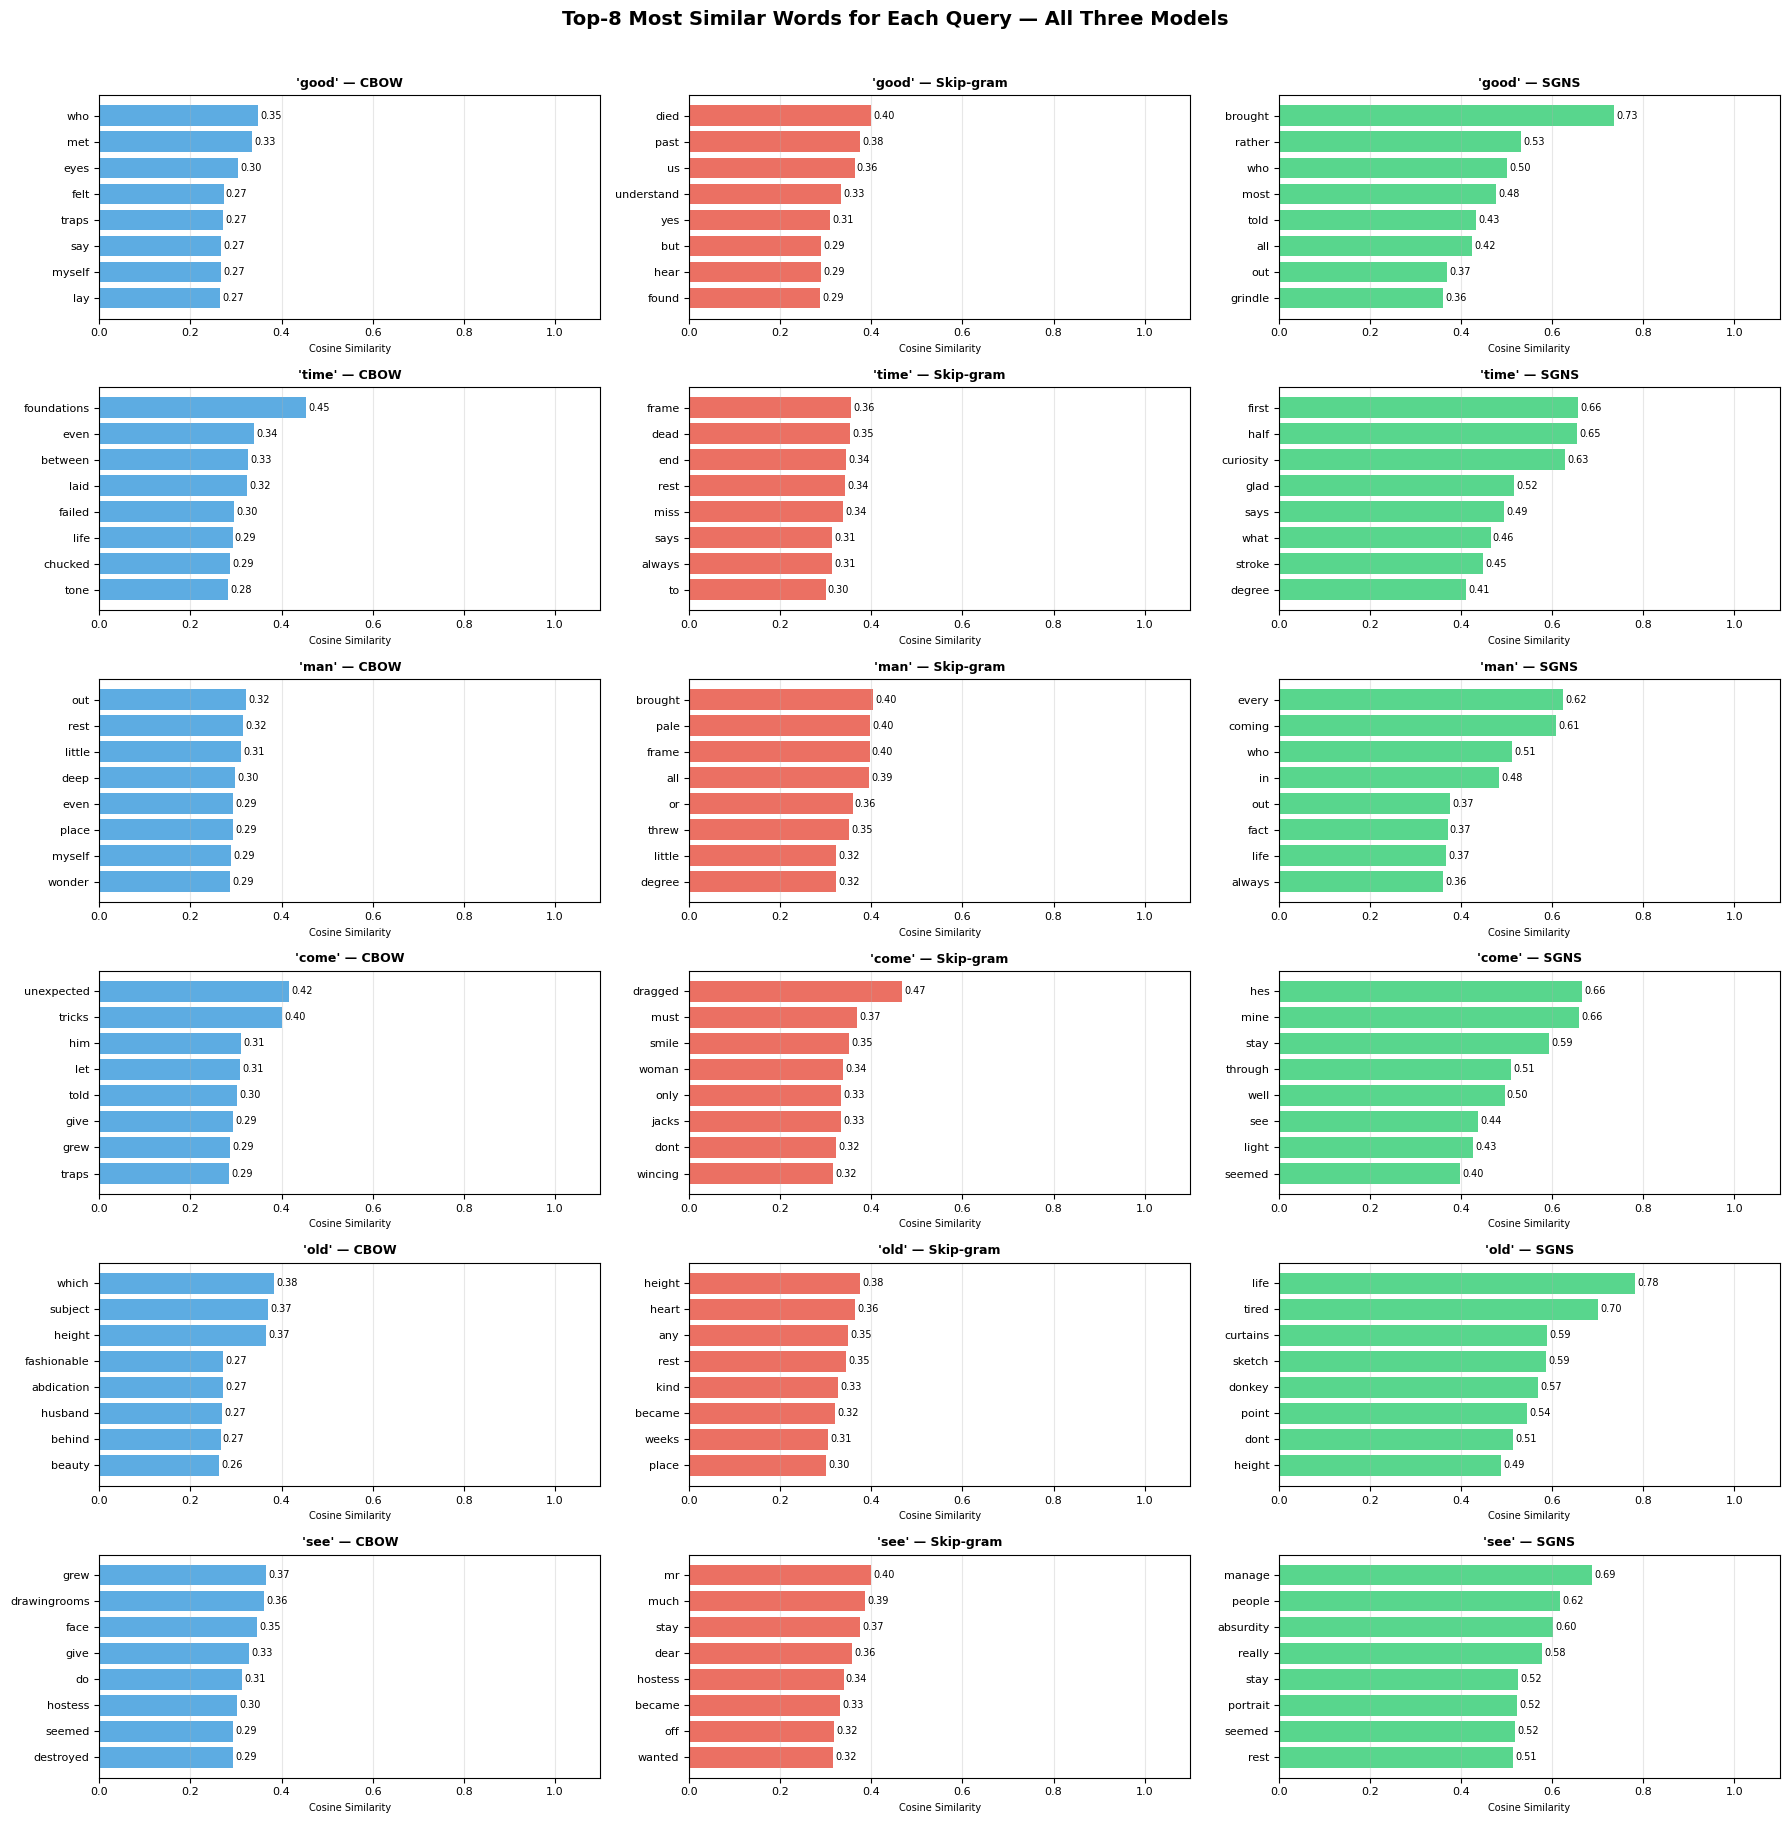

Saved: most_similar_charts.png


In [33]:
# Pick 6 interesting words and show top-8 similar words for each model
chart_words = ["good", "time", "man", "come", "old", "see"]
TOPN_CHART  = 8

fig, axes = plt.subplots(len(chart_words), 3,
                          figsize=(18, len(chart_words) * 3))
model_info = [
    ("CBOW",     cbow_emb, "#3498db"),
    ("Skip-gram", sg_emb,  "#e74c3c"),
    ("SGNS",     sgns_emb, "#2ecc71"),
]

for row_idx, query in enumerate(chart_words):
    for col_idx, (mname, emb, color) in enumerate(model_info):
        ax      = axes[row_idx][col_idx]
        results = most_similar(query, emb, w2i, i2w, topn=TOPN_CHART)

        if not results:
            ax.text(0.5, 0.5, f"'{query}' not in vocab",
                    ha='center', va='center', transform=ax.transAxes)
            ax.set_axis_off()
            continue

        words_r = [r[0] for r in results]
        sims_r  = [r[1] for r in results]

        bars = ax.barh(words_r[::-1], sims_r[::-1], color=color, alpha=0.8)
        for bar, sim in zip(bars, sims_r[::-1]):
            ax.text(bar.get_width() + 0.005, bar.get_y() + bar.get_height()/2,
                    f"{sim:.2f}", va='center', fontsize=7)

        ax.set_xlim(0, 1.1)
        ax.set_title(f"'{query}' — {mname}", fontsize=9, fontweight='bold')
        ax.set_xlabel("Cosine Similarity", fontsize=7)
        ax.tick_params(labelsize=8)
        ax.grid(axis='x', alpha=0.3)

plt.suptitle("Top-8 Most Similar Words for Each Query — All Three Models",
             fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("most_similar_charts.png", dpi=130, bbox_inches='tight')
plt.show()
print("Saved: most_similar_charts.png")

---
## Cell 15 — Least Similar Words

In [34]:
print("Least similar words (words that are most dissimilar in embedding space)")
print("=" * 65)

for query in ["good", "man", "time", "see", "right"]:
    print(f"\nQuery: '{query}'")
    for mname, emb in [("CBOW", cbow_emb), ("Skip-gram", sg_emb), ("SGNS", sgns_emb)]:
        results = least_similar(query, emb, w2i, i2w, topn=5)
        if not results:
            continue
        words_str = "  ".join([f"{w}({s:+.3f})" for w, s in results])
        print(f"  {mname:<12}: {words_str}")

Least similar words (words that are most dissimilar in embedding space)

Query: 'good'
  CBOW        : even(-0.335)  they(-0.258)  own(-0.245)  being(-0.241)  honour(-0.239)
  Skip-gram   : done(-0.287)  him(-0.219)  resolve(-0.209)  look(-0.194)  curtains(-0.187)
  SGNS        : between(-0.357)  laugh(-0.338)  things(-0.335)  tried(-0.333)  jacks(-0.329)

Query: 'man'
  CBOW        : past(-0.293)  rickham(-0.288)  mrs(-0.251)  attention(-0.242)  sent(-0.240)
  Skip-gram   : remember(-0.198)  left(-0.188)  me(-0.186)  yes(-0.186)  paint(-0.180)
  SGNS        : turned(-0.458)  wouldnt(-0.385)  grindles(-0.366)  still(-0.352)  hostess(-0.345)

Query: 'time'
  CBOW        : understand(-0.359)  believed(-0.305)  days(-0.248)  having(-0.245)  want(-0.243)
  Skip-gram   : behind(-0.291)  could(-0.271)  asked(-0.249)  ever(-0.210)  seen(-0.208)
  SGNS        : spite(-0.390)  married(-0.375)  rich(-0.367)  and(-0.364)  subject(-0.337)

Query: 'see'
  CBOW        : till(-0.300)  moved(-0.271)  

---
## Cell 16 — Embedding Arithmetic (Analogies)

Test vector arithmetic across all three models.
Results vary significantly by model architecture and dataset size.

In [35]:
analogy_queries = [
    (["men",  "good"],   ["man"],   "men + good - man"),
    (["good", "great"],  ["bad"],   "good + great - bad"),
    (["see",  "know"],   ["think"], "see + know - think"),
    (["work", "time"],   ["come"],  "work + time - come"),
    (["old",  "right"],  ["new"],   "old + right - new"),
    (["face", "eye"],    ["hand"],  "face + eye - hand"),
    (["come"],           ["go"],    "come - go"),
    (["room", "door"],   ["house"], "room + door - house"),
]

print("=" * 70)
print("EMBEDDING ARITHMETIC RESULTS")
print("=" * 70)

for pos, neg, label in analogy_queries:
    print(f"\nQuery: {label}")
    print("-" * 50)
    for mname, emb in [("CBOW", cbow_emb), ("Skip-gram", sg_emb), ("SGNS", sgns_emb)]:
        used, missing, results = analogy(pos, neg, emb, w2i, i2w, topn=5)
        if missing:
            miss_str = f" [missing: {missing}]"
        else:
            miss_str = ""
        res_str = ", ".join([f"{w}({s:.2f})" for w, s in results])
        print(f"  {mname:<12}{miss_str}")
        print(f"  -> {res_str}")

EMBEDDING ARITHMETIC RESULTS

Query: men + good - man
--------------------------------------------------
  CBOW         [missing: ['men']]
  -> past(0.39), met(0.35), attention(0.33), mrs(0.32), rickham(0.32)
  Skip-gram    [missing: ['men']]
  -> yes(0.38), understand(0.34), us(0.30), didnt(0.30), riviera(0.25)
  SGNS         [missing: ['men']]
  -> rather(0.58), wouldnt(0.47), turned(0.38), hostess(0.37), rickham(0.35)

Query: good + great - bad
--------------------------------------------------
  CBOW         [missing: ['bad']]
  -> himself(0.36), wife(0.34), cry(0.33), doesnt(0.33), word(0.32)
  Skip-gram    [missing: ['bad']]
  -> drawingrooms(0.38), is(0.38), without(0.36), glory(0.36), interesting(0.34)
  SGNS         [missing: ['bad']]
  -> thing(0.54), brought(0.49), surprise(0.45), no(0.41), called(0.40)

Query: see + know - think
--------------------------------------------------
  CBOW        
  -> stand(0.36), close(0.30), grew(0.28), much(0.27), hostess(0.25)
  Skip-gram 

---
## Cell 17 — Similarity Change: Random vs Trained vs More Epochs

Shows concretely how training changes the similarity structure of the embedding space.

Training 3-epoch CBOW...
  Epoch  1/3  loss: 5.7937


  Epoch  2/3  loss: 5.0748
  Epoch  3/3  loss: 4.5582

Pair                   Type                     Random     3 ep    15 ep
  good / great         synonyms                -0.009  -0.091  -0.193
  man / men            morphological              N/A     N/A     N/A
  come / go            antonyms                +0.194  +0.010  +0.254
  old / new            antonyms                   N/A     N/A     N/A
  time / work          topically related       +0.222  +0.181  -0.200
  door / think         unrelated                  N/A     N/A     N/A
  eye / come           unrelated                  N/A     N/A     N/A
  good / man           unrelated               -0.150  +0.177  +0.002


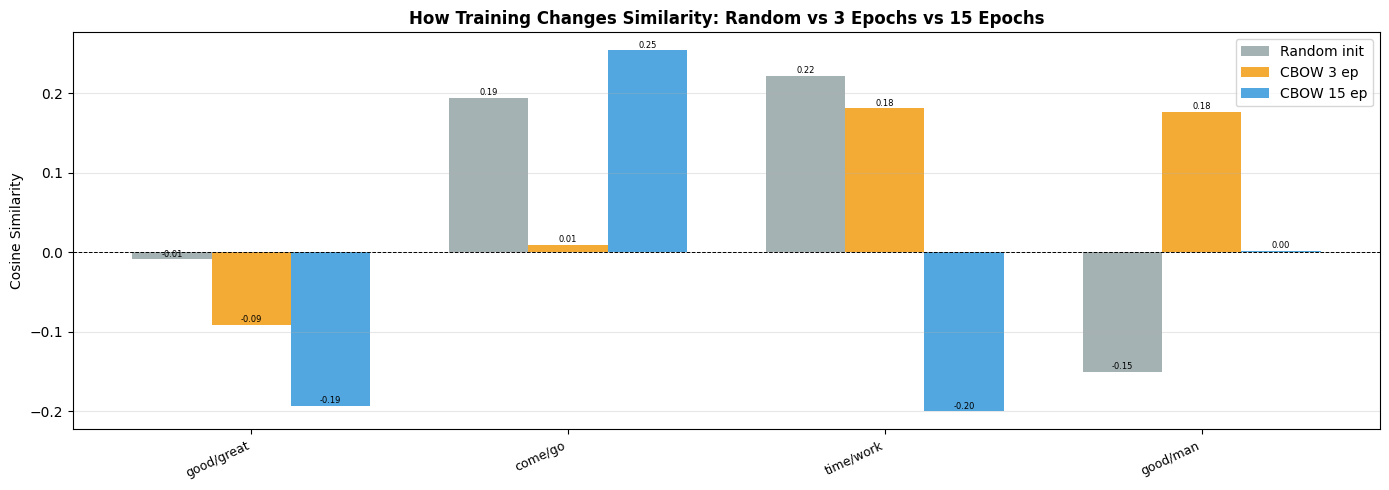

Saved: similarity_over_training.png


In [36]:
# Random embeddings baseline
torch.manual_seed(99)
random_emb = torch.randn(V, EMBED_DIM)

# 3-epoch CBOW (undertrained)
cbow_3ep        = CBOWModel(V, EMBED_DIM)
print("Training 3-epoch CBOW...")
train_cbow(cbow_3ep, cbow_data, epochs=3, batch_size=BATCH, lr=LR)
cbow_3ep_emb    = cbow_3ep.get_embeddings()

# Use full 15-epoch CBOW already trained
cbow_15ep_emb   = cbow_emb

tracked_pairs = [
    ("good",  "great",  "synonyms"),
    ("man",   "men",    "morphological"),
    ("come",  "go",     "antonyms"),
    ("old",   "new",    "antonyms"),
    ("time",  "work",   "topically related"),
    ("door",  "think",  "unrelated"),
    ("eye",   "come",   "unrelated"),
    ("good",  "man",    "unrelated"),
]

print("\n" + "=" * 72)
print(f"{'Pair':<22} {'Type':<22} {'Random':>8} {'3 ep':>8} {'15 ep':>8}")
print("=" * 72)

rand_sims, ep3_sims, ep15_sims, pair_labels = [], [], [], []

for w1, w2, label in tracked_pairs:
    sr  = cosine_sim(w1, w2, random_emb,    w2i)
    s3  = cosine_sim(w1, w2, cbow_3ep_emb,  w2i)
    s15 = cosine_sim(w1, w2, cbow_15ep_emb, w2i)

    pair_str = f"{w1} / {w2}"
    print(f"  {pair_str:<20} {label:<22}", end="")
    for s in [sr, s3, s15]:
        if s is not None:
            print(f"  {s:>+6.3f}", end="")
        else:
            print(f"  {'N/A':>6}", end="")
    print()

    if all(s is not None for s in [sr, s3, s15]):
        rand_sims.append(sr)
        ep3_sims.append(s3)
        ep15_sims.append(s15)
        pair_labels.append(f"{w1}/{w2}")

# Plot
x  = np.arange(len(pair_labels))
w  = 0.25
fig, ax = plt.subplots(figsize=(14, 5))
b1 = ax.bar(x - w, rand_sims,  w, label='Random init', color='#95a5a6', alpha=0.85)
b2 = ax.bar(x,     ep3_sims,   w, label='CBOW 3 ep',   color='#f39c12', alpha=0.85)
b3 = ax.bar(x + w, ep15_sims,  w, label='CBOW 15 ep',  color='#3498db', alpha=0.85)

ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=25, ha='right', fontsize=9)
ax.axhline(0, color='black', linewidth=0.7, linestyle='--')
ax.set_ylabel("Cosine Similarity")
ax.set_title("How Training Changes Similarity: Random vs 3 Epochs vs 15 Epochs",
             fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
for bars in [b1, b2, b3]:
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"{h:.2f}",
                    xy=(bar.get_x() + bar.get_width()/2, h),
                    xytext=(0, 2), textcoords='offset points',
                    ha='center', fontsize=6)
plt.tight_layout()
plt.savefig("similarity_over_training.png", dpi=150, bbox_inches='tight')
plt.show()
print("Saved: similarity_over_training.png")

---
## Cell 18 — PCA: All Three Models Side by Side

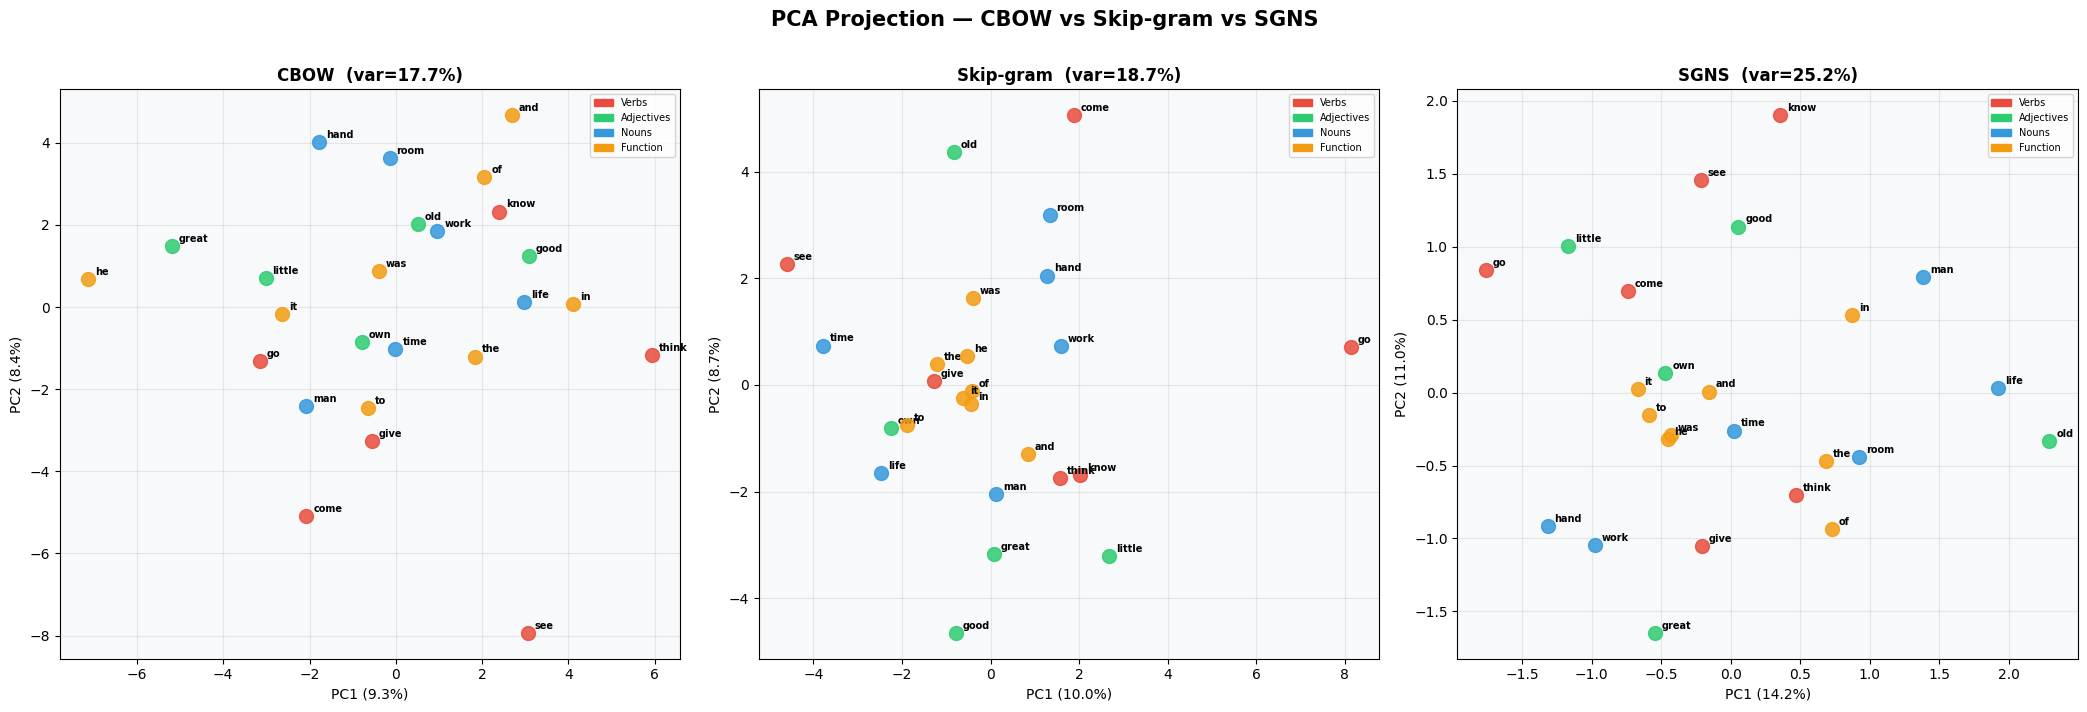

Saved: pca_all_models.png


In [37]:
word_groups = {
    "Verbs"      : ["come",  "go",    "see",   "know",  "think", "make",  "give",  "take"],
    "Adjectives" : ["good",  "great", "old",   "new",   "little","own",   "right", "long"],
    "Nouns"      : ["man",   "time",  "work",  "hand",  "eye",   "room",  "door",  "life"],
    "Function"   : ["the",   "of",    "and",   "to",    "in",    "was",   "he",    "it"],
}
colors = ["#e74c3c", "#2ecc71", "#3498db", "#f39c12"]

def get_group_vectors(embeddings, w2i, word_groups):
    all_w, all_v, all_c = [], [], []
    for (grp, wlist), col in zip(word_groups.items(), colors):
        for w in wlist:
            v = get_vec(w, embeddings, w2i)
            if v is not None:
                all_w.append(w)
                all_v.append(v.numpy())
                all_c.append(col)
    return all_w, all_v, all_c

patches = [mpatches.Patch(color=c, label=g)
           for g, c in zip(word_groups.keys(), colors)]

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for ax, (mname, emb) in zip(axes, [("CBOW", cbow_emb), ("Skip-gram", sg_emb), ("SGNS", sgns_emb)]):
    all_w, all_v, all_c = get_group_vectors(emb, w2i, word_groups)
    if len(all_v) < 2:
        ax.set_title(f"{mname} — not enough words")
        continue

    pca    = PCA(n_components=2)
    vecs2d = pca.fit_transform(np.array(all_v))
    var    = pca.explained_variance_ratio_.sum() * 100

    ax.set_facecolor("#f8f9fa")
    for w, coord, col in zip(all_w, vecs2d, all_c):
        ax.scatter(coord[0], coord[1], c=col, s=100, zorder=3, alpha=0.85)
        ax.annotate(w, coord, textcoords="offset points",
                    xytext=(5, 3), fontsize=7, fontweight='bold')

    ax.legend(handles=patches, fontsize=7, loc='upper right')
    ax.set_title(f"{mname}  (var={var:.1f}%)", fontsize=12, fontweight='bold')
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    ax.grid(True, alpha=0.25)

plt.suptitle("PCA Projection — CBOW vs Skip-gram vs SGNS",
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("pca_all_models.png", dpi=140, bbox_inches='tight')
plt.show()
print("Saved: pca_all_models.png")

---
## Cell 19 — t-SNE: All Three Models

TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

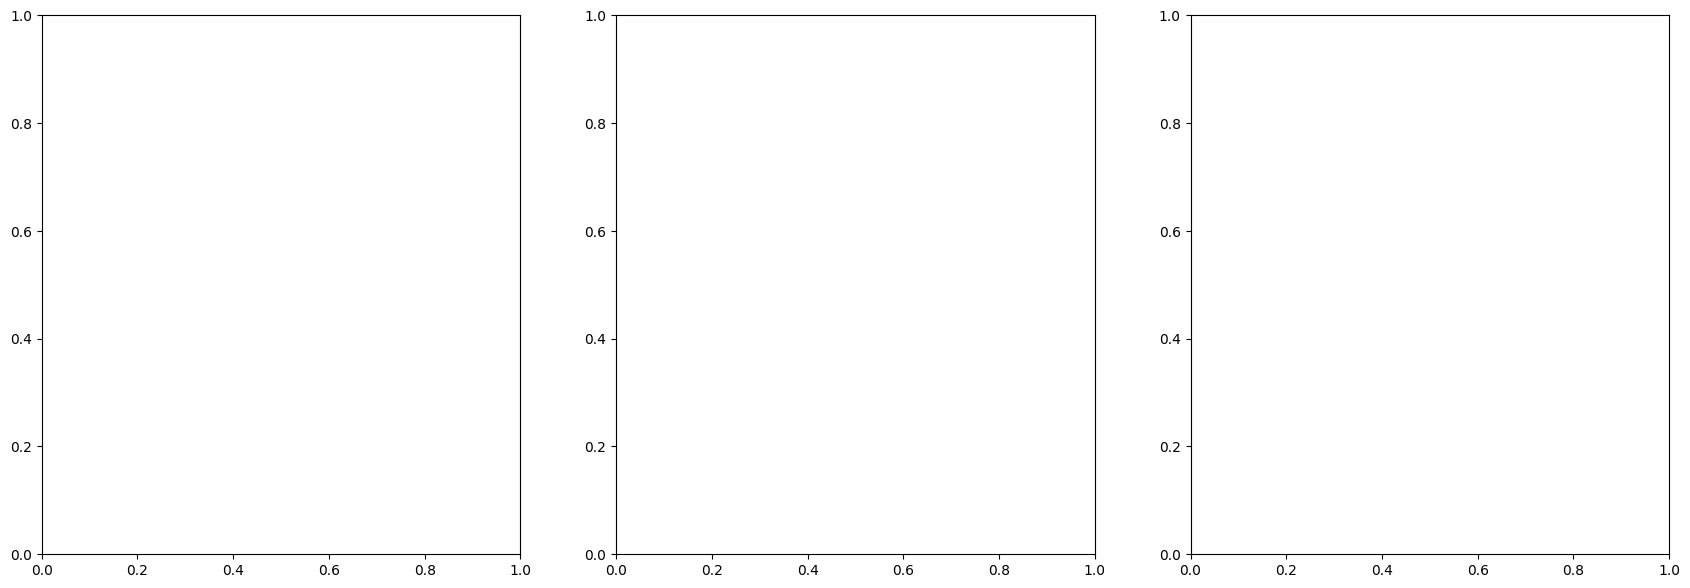

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for ax, (mname, emb) in zip(axes, [("CBOW", cbow_emb), ("Skip-gram", sg_emb), ("SGNS", sgns_emb)]):
    all_w, all_v, all_c = get_group_vectors(emb, w2i, word_groups)
    if len(all_v) < 4:
        continue

    perp     = min(15, len(all_w) - 1)
    tsne     = TSNE(n_components=2, perplexity=perp, random_state=42, n_iter=1000)
    vecs_tsne = tsne.fit_transform(np.array(all_v))

    ax.set_facecolor("#f8f9fa")
    for w, coord, col in zip(all_w, vecs_tsne, all_c):
        ax.scatter(coord[0], coord[1], c=col, s=100, zorder=3, alpha=0.85)
        ax.annotate(w, coord, textcoords="offset points",
                    xytext=(5, 3), fontsize=7, fontweight='bold')

    ax.legend(handles=patches, fontsize=7, loc='upper right')
    ax.set_title(f"{mname} — t-SNE", fontsize=12, fontweight='bold')
    ax.set_xlabel("Dim 1"); ax.set_ylabel("Dim 2")
    ax.grid(True, alpha=0.25)

plt.suptitle("t-SNE Projection — CBOW vs Skip-gram vs SGNS",
             fontsize=15, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig("tsne_all_models.png", dpi=140, bbox_inches='tight')
plt.show()
print("Saved: tsne_all_models.png")

---
## Cell 20 — Cosine Similarity Heatmap (Best Model)

In [ ]:
hmap_words = [
    "good", "great", "old", "new", "man", "men",
    "come", "go",    "see", "know", "time", "work"
]
hmap_words = [w for w in hmap_words if w in w2i]

fig, axes = plt.subplots(1, 3, figsize=(21, 7))

for ax, (mname, emb) in zip(axes, [("CBOW", cbow_emb), ("Skip-gram", sg_emb), ("SGNS", sgns_emb)]):
    vecs  = np.array([get_vec(w, emb, w2i).numpy() for w in hmap_words])
    sim_m = cos_matrix(vecs)

    im = ax.imshow(sim_m, cmap="RdYlGn", vmin=-1, vmax=1)
    ax.set_xticks(range(len(hmap_words)))
    ax.set_yticks(range(len(hmap_words)))
    ax.set_xticklabels(hmap_words, rotation=45, ha='right', fontsize=9)
    ax.set_yticklabels(hmap_words, fontsize=9)

    for i in range(len(hmap_words)):
        for j in range(len(hmap_words)):
            v = sim_m[i, j]
            ax.text(j, i, f"{v:.2f}", ha='center', va='center',
                    fontsize=6.5, fontweight='bold',
                    color='white' if abs(v) > 0.5 else 'black')

    plt.colorbar(im, ax=ax, shrink=0.8)
    ax.set_title(f"{mname} — Cosine Similarity Matrix", fontsize=11, fontweight='bold')

plt.suptitle("Cosine Similarity Heatmaps — All Three Models",
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig("heatmap_all_models.png", dpi=140, bbox_inches='tight')
plt.show()
print("Saved: heatmap_all_models.png")

---
## Cell 21 — Nearest Neighbor Table (Formatted)

In [ ]:
# Print a clean neighbor table for all query words, best model (SGNS)
TABLE_WORDS = [
    "good",  "time",  "man",   "come",  "see",
    "work",  "hand",  "old",   "right", "life",
    "room",  "eye",   "little","know",  "great",
    "go",    "new",   "long",  "door",  "give",
]
N_NEIGHBORS = 6

print("NEAREST NEIGHBOR TABLE — SGNS Embeddings")
print("=" * 80)
print(f"{'Query':<10}", end="")
for i in range(1, N_NEIGHBORS+1):
    print(f"  {'Rank '+str(i):<16}", end="")
print()
print("-" * 80)

for query in TABLE_WORDS:
    results = most_similar(query, sgns_emb, w2i, i2w, topn=N_NEIGHBORS)
    if not results:
        print(f"{query:<10}  (not in vocab)")
        continue
    print(f"{query:<10}", end="")
    for w, s in results:
        cell = f"{w}({s:.2f})"
        print(f"  {cell:<16}", end="")
    print()

print("=" * 80)

---
## Cell 22 — Model Comparison Summary Table

In [ ]:
# Compute aggregate statistics for each model
# Average cosine similarity across synonym and unrelated pairs
syn_pairs   = [("good","great"),("old","new"),("come","go"),("see","look"),("work","time")]
unrel_pairs = [("door","think"),("eye","come"),("hand","right"),("time","man"),("old","room")]

def avg_sim(pairs, emb, w2i):
    sims = [cosine_sim(w1, w2, emb, w2i) for w1, w2 in pairs]
    sims = [s for s in sims if s is not None]
    return sum(sims) / len(sims) if sims else 0.0

def avg_top1_sim(words, emb, w2i, i2w):
    """Average similarity to the top-1 nearest neighbor."""
    vals = []
    for w in words:
        res = most_similar(w, emb, w2i, i2w, topn=1)
        if res:
            vals.append(res[0][1])
    return sum(vals) / len(vals) if vals else 0.0

probe_words = [w for w in TABLE_WORDS if w in w2i]

print("=" * 72)
print("MODEL COMPARISON SUMMARY")
print("=" * 72)
print(f"{'Metric':<35} {'CBOW':>10} {'Skip-gram':>12} {'SGNS':>10}")
print("-" * 72)

rows = [
    ("Architecture",                  "CBOW",        "Skip-gram",    "SGNS"),
    ("Prediction direction",          "ctx->center",  "center->ctx",  "binary cls"),
    ("Loss function",                 "cross-entropy","cross-entropy","binary CE"),
    ("Embedding tables",              "1",            "1",            "2 (avg)"),
    ("Final training loss",
        f"{cbow_history[-1]:.4f}",
        f"{sg_history[-1]:.4f}",
        f"{sgns_history[-1]:.4f}"),
    ("Avg sim (synonym pairs)",
        f"{avg_sim(syn_pairs, cbow_emb, w2i):.4f}",
        f"{avg_sim(syn_pairs, sg_emb, w2i):.4f}",
        f"{avg_sim(syn_pairs, sgns_emb, w2i):.4f}"),
    ("Avg sim (unrelated pairs)",
        f"{avg_sim(unrel_pairs, cbow_emb, w2i):.4f}",
        f"{avg_sim(unrel_pairs, sg_emb, w2i):.4f}",
        f"{avg_sim(unrel_pairs, sgns_emb, w2i):.4f}"),
    ("Avg top-1 neighbor similarity",
        f"{avg_top1_sim(probe_words, cbow_emb, w2i, i2w):.4f}",
        f"{avg_top1_sim(probe_words, sg_emb, w2i, i2w):.4f}",
        f"{avg_top1_sim(probe_words, sgns_emb, w2i, i2w):.4f}"),
    ("Vocab size",    str(V), str(V), str(V)),
    ("Embed dim",     str(EMBED_DIM), str(EMBED_DIM), str(EMBED_DIM)),
    ("Epochs trained",str(EPOCHS), str(EPOCHS), str(EPOCHS)),
    ("Window size",   str(WINDOW), str(WINDOW), str(WINDOW)),
]

for row in rows:
    label = row[0]
    vals  = row[1:]
    print(f"{label:<35} {vals[0]:>10} {vals[1]:>12} {vals[2]:>10}")

print("=" * 72)
print("\nNotes:")
print("  - CBOW learns better on frequent words; averages context info")
print("  - Skip-gram learns better on rare words; each context is a separate signal")
print("  - SGNS trains faster and scales to larger corpora; avoids full softmax")
print("  - All three converge to similar quality on small datasets")
print("  - Results improve substantially with larger training corpora")

---
## Cell 23 — Saved Output Files

In [ ]:
saved_files = [
    "w2v_loss_comparison.png",
    "most_similar_charts.png",
    "similarity_over_training.png",
    "pca_all_models.png",
    "tsne_all_models.png",
    "heatmap_all_models.png",
]

print("Output files:")
print("-" * 45)
for f in saved_files:
    status = "OK" if os.path.exists(f) else "MISSING"
    size   = f"{os.path.getsize(f)/1024:.0f} KB" if os.path.exists(f) else ""
    print(f"  [{status}]  {f:<40} {size}")

print()
print("Notebook complete.")